In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.optimize
import urllib
from typing import Tuple
from random import randint

# Part 1 - Principal Component Analysis

## Part 1.1 - Implement PCA

### Restrictions

The use of `sklearn.decomposition.PCA` or `np.cov` is prohibited. You cannot use for loops!! Make sure your operations are vectorized.

In [2]:
def pca(X: np.ndarray, K: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    X is an N*D matrix of data (N points in D dimensions)
    K is the desired maximum target dimensionality (K <= min{N,D})
    should return a tuple (P, Z, evals)
    where P is the projected data (N*K) where
    the first dimension is the higest variance,
    the second dimension is the second higest variance, etc.
    Z is the projection matrix (D*K) that projects the data into
    the low dimensional space (i.e., P = X * Z).
    and evals, a K dimensional array of eigenvalues (sorted)
    """
    N, D = X.shape
    
    # make sure we don't look for too many eigs!
    if K > N:
        K = N
    if K > D:
        K = D
    
    ### TODO: YOUR CODE HERE
    mu = np.mean(X)
    D = np.divide(np.matmul((X - mu * np.ones((1, N)).transpose()).transpose(),(X - mu * np.ones((1, N)).transpose())), N - 1)
    evals, evec = np.linalg.eig([D])
    evals, Z = np.real(evals[0, :K]), np.real(evec[0, :, :K])
    arrange_index = evals.argsort()[::-1]
    arrange_index = arrange_index[:K]
    evals = evals[arrange_index]
    Z = Z[:, arrange_index]
    P = np.matmul((X - mu * np.ones((1, N)).transpose()), Z)
    return (P, Z, evals)

Our first test of PCA will be on Gaussian data with a known covariance matrix. First, let's generate some data and see how it looks.

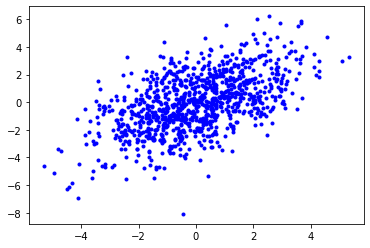

In [3]:
M = np.array([[3,2],[2,4]])
(U,S,VT) = np.linalg.svd(M)
D = np.diag(np.sqrt(S))

Si = U @ D @ VT
x = np.random.randn(1000,2) @ Si
plt.plot(x[:,0], x[:,1], 'b.');

Now, let's run PCA on this data. We basically know what should happen, but let's make sure it happens anyway (still, given the random nature, the numbers won't be exactly the same). We can project the data onto the first eigenvalue and plot it in red, and the second eigenvalue in green. 

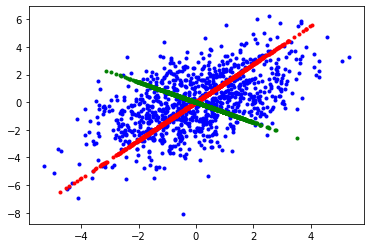

In [4]:
(P, Z, evals) = pca(x, 2)

x0 = (x @ Z[:,0,None]) * Z[:,0,None].T
x1 = (x @ Z[:,1,None]) * Z[:,1,None].T

plt.plot(x[:,0], x[:,1], 'b.', x0[:,0], x0[:,1], 'r.', x1[:,0], x1[:,1], 'g.');

## Part 1.2 - Visualization of MNIST

Lets work with some [handwritten digits](https://en.wikipedia.org/wiki/MNIST_database). Before we try PCA on them, let's visualize the digits. Below are helper functions meant to help you visualize the MNIST data, specifically the method `draw_digits`.

The following specification characterizes `draw_digits`:
1. Visualizes `K` random samples from `X`, with no repeats.
2. Digits are visualized on 5 column subplots.
3. A gray colormap is used to visualize the digits.
4. The label of the digit is added as white text on the upper left corner of the subplot, with font size 16.
5. `X` is the first returned value from `load_digits` (raw MNIST image entries), and `Y` is the second returned value from `load_digits` (labels of image entries).

In [5]:
np.random.seed(0)

def draw_digits(X: np.ndarray, Y: np.ndarray, K: int = 20):
    plt.rcParams["figure.figsize"] = (20,20)
    shown = list(range(0, X.shape[0]))
    
    for i in range(K):
        temp = randint(0, len(shown)-1)
        ind = shown[temp]
        del shown[temp]
        
        pixels = X[ind,]
        pixels = np.rot90(np.flip(pixels.reshape((28, 28)), 1))
        
        ax = plt.subplot(K/5, 5, i+1)
        ax.imshow(pixels, cmap='gray')
        ax.text(0.1, 0.9, Y[ind], color='white', fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        ax.axis('off')
        
    plt.show()

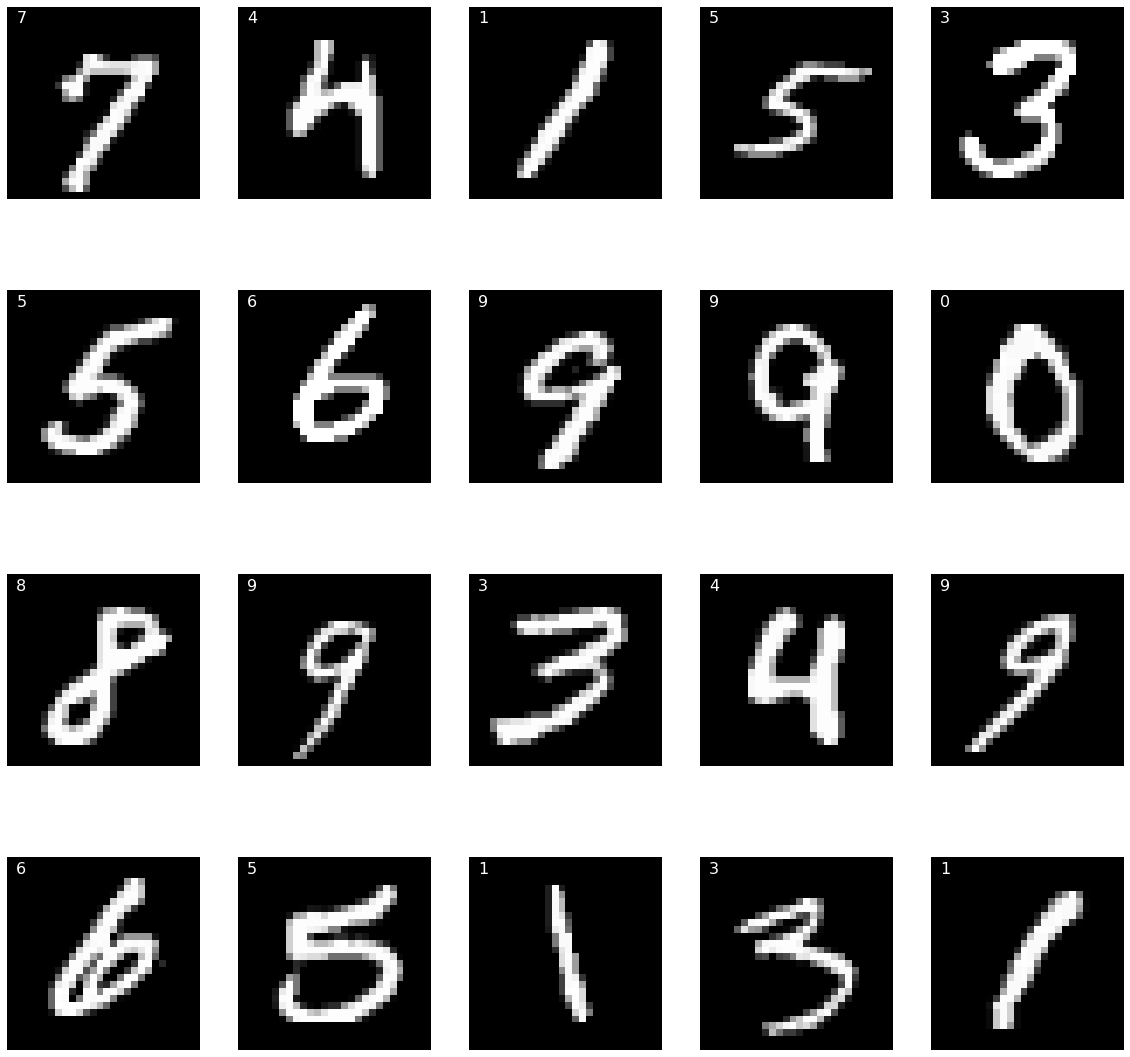

In [6]:
def load_digits():
    X = np.zeros((1000, 784), dtype=float)
    Y = np.zeros((1000,), dtype=int)

    with open('data/digits') as f:
        for idx, line in enumerate(f):
            vals = [int(v) for v in line.split()]
            Y[idx] = vals[0] % 10
            for i in range(len(vals)//2-1):
                X[idx, vals[i*2+1]] = float(vals[i*2+2])
            X[idx,:] = X[idx,:] / np.linalg.norm(X[idx,:])

    return X, Y

X, Y = load_digits()
draw_digits(X, Y)

## 1.3 - Plotting Explained Variance

Let's examine all the principal components of the digits data.

Plot (using matplotlib) the explained variance of the principal components, with x-axis being the number of principal components, and the y-axis being the percent variance explained. How many eigenvectors do you have to include before you've accounted for 90% of the variance?
95%? Label these points on your plot.

61
107


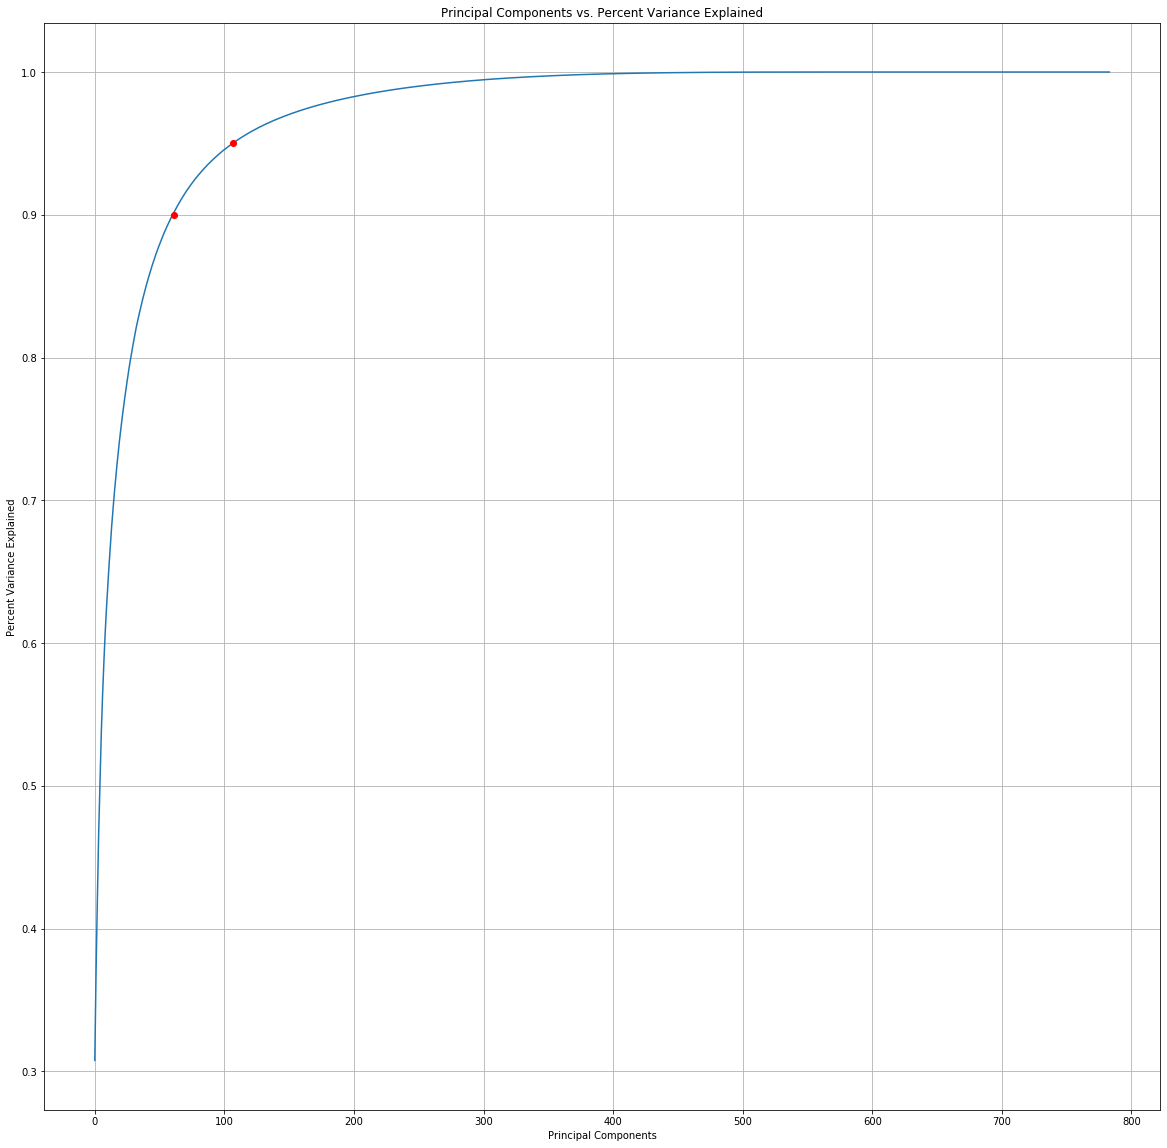

In [7]:
(P, Z, evals) = pca(X, 784)

### TODO: YOUR CODE HERE
ninetyPercent_index = 0
ninetyFivePercent_index = 0
ratioVariance = np.cumsum(evals) / np.sum(evals)

for i in range(len(evals)):
    if ratioVariance[i] >= .9:
        ninetyPercent_index = i
        break

for i in range(len(evals)):
    if ratioVariance[i] >= .95:
        ninetyFivePercent_index = i
        break

print(ninetyPercent_index)
print(ninetyFivePercent_index)

plt.xlabel('Principal Components')
plt.ylabel('Percent Variance Explained')
plt.title('Principal Components vs. Percent Variance Explained')
plt.plot(ratioVariance)
plt.grid(True)
plt.plot([ninetyPercent_index,ninetyFivePercent_index], [.9,.95], 'ro')
plt.show()

Eventually, the eigenvalues drop to zero (note that some may be negative due to floating point errors).

**ANSWER**:

## Part 1.4 - Visualization of Dimensionality Reduction

Now, let's plot the top 50 eigenvectors:

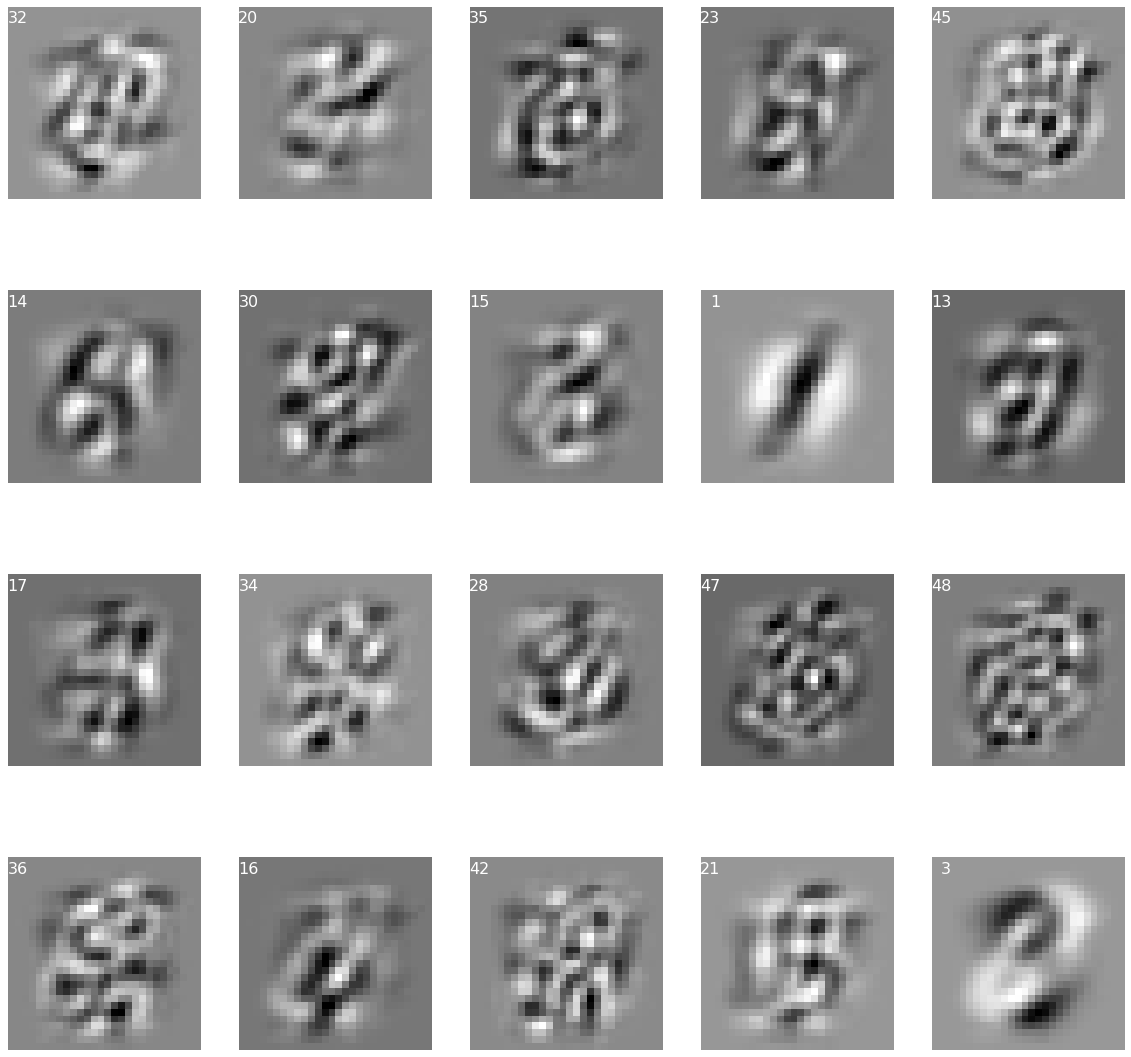

In [8]:
# DO NOT EDIT
draw_digits(Z.T[:50,:], np.arange(50))

Do these look like digits? Should they? Why or why not?

**ANSWER:** They have very little resemblance to digits 
(Exception is plot 7 which is very close to digit 1) 
Overall, it is fair to say they do not look like digits and they need not look like digits as we are:

1) Only plotting the top 50 eigenvectors and a lot of the content in the data is lost through this.

2) Only the largely varying features are chosen in this process and this might not correlate to the visual depiction of the digit images and depend more on how the features are varying.